In [1]:
# imports

import os
import subprocess
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from plots import plot9images, plot_confusion_matrix, plot_histogram_from_labels
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

print("PyTorch version = {} ".format(torch.__version__))

PyTorch version = 0.4.0 


In [2]:
# load data

train_X = np.load('train_data.npy')[0:10000] / 255
train_y = np.load('train_labels.npy')[0:10000]
valid1_X = np.load('valid_data1.npy') / 255
valid1_y = np.load('valid_labels1.npy')
valid2_X = np.load('valid_data2.npy') / 255
valid2_y = np.load('valid_labels2.npy')
test_X = np.load('test_track_data.npy') / 255

def labels2csv(labels, csv_path):
    with open(csv_path, "w") as file:
        file.write("id,label\n")
        for i, label in enumerate(labels):
            file.write("{},{}\n".format(i,label))

In [3]:
# define hyperparams

class LRConfig(object):
    """
    Holds logistic regression model hyperparams.
    
    :param height: image height
    :type heights: int
    :param width: image width
    :type width: int
    :param channels: image channels
    :type channels: int
    :param batch_size: batch size for training
    :type batch_size: int
    :param epochs: number of epochs
    :type epochs: int
    :param save_step: when step % save_step == 0, the model
                      parameters are saved.
    :type save_step: int
    :param learning_rate: learning rate for the optimizer
    :type learning_rate: float
    :param momentum: momentum param
    :type momentum: float
    """
    def __init__(self,
                 height=45,
                 width=80,
                 channels=3,
                 classes=3,
                 batch_size=32,
                 epochs=3,
                 learning_rate=0.01,
                 momentum=0.1,
                 save_step=100,
                 weight_decay=0.1,
                 architecture=[100, 3]):
        self.height = height
        self.width = width
        self.classes = classes
        self.channels = channels
        self.batch_size = batch_size
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.architecture = architecture
        self.save_step = save_step
        self.weight_decay = weight_decay
        

    def __str__(self):
        """
        Get all attributs values.
        :return: all hyperparams as a string
        :rtype: str
        """
        status = "height = {}\n".format(self.height)
        status += "width = {}\n".format(self.width)
        status += "channels = {}\n".format(self.channels)
        status += "classes = {}\n".format(self.classes)
        status += "batch_size = {}\n".format(self.batch_size)
        status += "epochs = {}\n".format(self.epochs)
        status += "learning_rate = {}\n".format(self.learning_rate)
        status += "momentum = {}\n".format(self.momentum)
        status += "architecture = {}\n".format(self.architecture)
        status += "save_step = {}\n".format(self.save_step)
        status += "weight_decay = {}\n".format(self.weight_decay)

        return status

In [4]:
# set hyperparams

lr_config = LRConfig()
lr_config.epochs = 35
lr_config.learning_rate = 0.03
lr_config.momentum = 0
lr_config.architecture = [300, 40, 3]
lr_config.weight_decay = 0
print("Os hiper parâmetros do modelo de regressão logística são:\n")
print(lr_config)

Os hiper parâmetros do modelo de regressão logística são:

height = 45
width = 80
channels = 3
classes = 3
batch_size = 32
epochs = 35
learning_rate = 0.03
momentum = 0
architecture = [300, 40, 3]
save_step = 100
weight_decay = 0



In [5]:
# organizing data

class DataHolder():
    """
    Class to store all data.

    :param config: hyper params configuration
    :type config: LRConfig or DFNConfig
    :param train_dataset: dataset of training data
    :type train_dataset: torch.utils.data.dataset.TensorDataset
    :param test_dataset: dataset of test data
    :type test_dataset: torch.utils.data.dataset.TensorDataset
    :param valid_dataset: dataset of valid data
    :type valid_dataset: torch.utils.data.dataset.TensorDataset
    :param batch_size: batch size for training
    :type test_batch: batch size for the testing data
    :param test_batch: int
    """
    def __init__(self,
                 config,
                 train_dataset,
                 valid_dataset,
                 test_dataset,
                 real_data):
        batch_size = config.batch_size        
        self.train_loader = DataLoader(dataset=train_dataset,
                                       batch_size=batch_size,
                                       shuffle=True)
        self.valid_loader = DataLoader(dataset=valid_dataset,
                                       batch_size=len(valid_dataset))
        self.test_loader = DataLoader(dataset=test_dataset,
                                      batch_size=len(test_dataset))
        self.real_data = torch.Tensor(real_data)        

train_dataset = TensorDataset(torch.Tensor(train_X),
                              torch.Tensor(train_y).type(torch.LongTensor))
valid1_dataset = TensorDataset(torch.Tensor(valid1_X),
                              torch.Tensor(valid1_y).type(torch.LongTensor))
valid2_dataset = TensorDataset(torch.Tensor(valid2_X),
                              torch.Tensor(valid2_y).type(torch.LongTensor))
self_driving_data = DataHolder(lr_config, train_dataset, valid1_dataset, valid2_dataset, test_X) 

In [6]:
# model trainer

def train_model_img_classification(model,
                                   config,
                                   dataholder,
                                   criterion, 
                                   optimizer):

    train_loader = dataholder.train_loader
    valid_loader = dataholder.valid_loader

    train_loss = []
    valid_loss = []
    for epoch in range(config.epochs):
        for step, (images, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            pred = model(images)
            loss = criterion(pred, labels) 
                    
            loss.backward()
            optimizer.step()
            
            if step % config.save_step == 0:
                train_loss.append(float(loss))
            
                # Test on validation data
                (v_images, v_labels) = next(iter(valid_loader))
                v_pred = model(v_images)
                v_loss = criterion(v_pred, v_labels)
                valid_loss.append(float(v_loss))

        v_candidates = model.predict(v_images)
        acc = v_candidates.eq(v_labels).sum()
        print("End of epoch %d | Validation loss: %.3f | Accuracy: %d / %d" % (epoch, float(v_loss), acc, len(v_labels)))
        acc = v_candidates.eq(v_labels).sum()
                        
    # Plot
    x = np.arange(1, len(train_loss) + 1, 1)
    fig, ax = plt.subplots(1, 1, figsize=(12, 5))
    ax.plot(x, train_loss, label='train loss')
    ax.plot(x, valid_loss, label='valid loss')
    ax.legend()
    plt.xlabel('step')
    plt.ylabel('loss')
    plt.title('Train and valid loss')
    plt.grid(True)
    plt.show()
        


In [7]:
# define DFN model

class DFN(nn.Module):

    def __init__(self, config):
        super(DFN, self).__init__()
        self.classes = config.classes
        self.params = config.height * config.width * config.channels
        self.num_layers = len(config.architecture)
        p_in = self.params
        for step, layer in enumerate(config.architecture):
            p_out = layer
            self.add_module("lin"+str(step), nn.Linear(p_in, p_out))
            self.add_module("relu"+str(step), nn.Tanh())
            p_in = p_out
        self.add_module("softmax", nn.Softmax(1))


    def forward(self, x):
        """
        Computes forward pass

        :param x: input tensor
        :type x: torch.FloatTensor(shape=(batch_size, number_of_features))
        :return: logits
        :rtype: torch.FloatTensor(shape=[batch_size, number_of_classes])
        """
        inn = x
        for i in range(self.num_layers):
            linear = getattr(self, "lin"+str(i))
            mid = linear(inn)
            relu = getattr(self, "relu"+str(i))
            out = relu(mid)
            inn = out
        logits = out
        return logits

    def predict(self, x):
        logits = self.forward(x)
        probs = self.softmax(logits)
        predictions = probs.argmax(dim=1)
        return predictions

In [ ]:
# define tools and train

model = DFN(lr_config)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr_config.learning_rate, lr_config.momentum, weight_decay=lr_config.weight_decay)
#optimizer = torch.optim.Adagrad(model.parameters(), lr_config.learning_rate, 0.01, lr_config.weight_decay)

train_model_img_classification(model,
                               lr_config,
                               self_driving_data,
                               criterion,
                               optimizer)

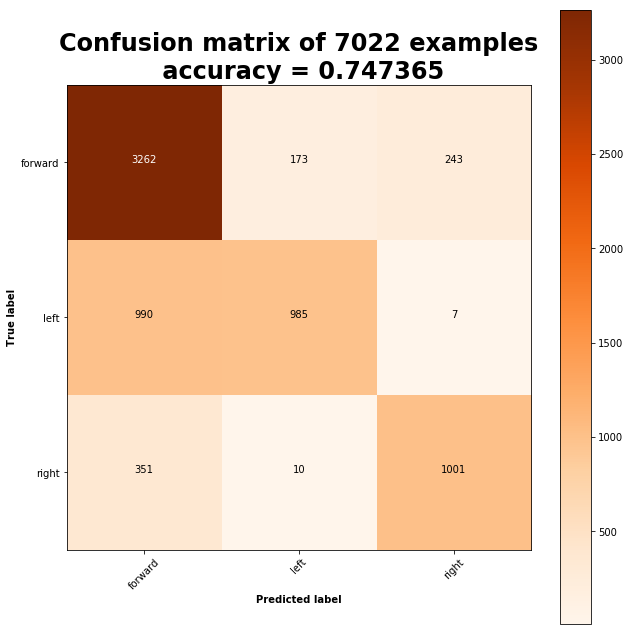

In [9]:
# run over test data and plot confusion

img, labels = next(iter(self_driving_data.test_loader))
pred = model.predict(img).numpy()

plot_confusion_matrix(truth=labels.numpy(),
                      predictions=pred,
                      save=False,
                      path="dfn_confusion_matrix.png",
                      classes=["forward", "left", "right"])

In [275]:
# run over submittable data and save CSV
preds = model.predict(self_driving_data.real_data).numpy()

labels2csv(preds, "submission.csv")